In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json

In [178]:
def group_flattened_experiment_results(results):
    df = pd.DataFrame(results)
    grp = df.groupby(['al_algorithm','trained_samples']).agg(['mean', 'median', 'var']).reset_index()
    grp.columns = [first if second == '' else first + '_' + second for first, second in grp.columns.values]
    return grp

In [166]:
def print_plot(results, title="Experiments"):
#     results = results.sort_values('al_algorithm', ascending=False)
    fig, ax =plt.subplots(figsize=(15,10))
    
    sns.lineplot(data=results, hue='al_algorithm', style='al_algorithm', x = "trained_samples",  y = "_f1", ci='sd',  ax = ax,
                 marker='o', 
                  palette=['goldenrod', 'indigo', 'darkgreen']
                )
#     ax.lines[0].set_linestyle("dotted")
#     ax.lines[2].set_linestyle("dotted")
    ax.legend( title = "F1-Score " + title)
    fig.show()

In [3]:
pd.read_json('results/full_runtimes.json', orient='records').drop(columns=['duration']).to_json('results/full_runtimes_new.json', orient='split')

In [252]:
def load_result(src:str):
    from datetime import datetime, timedelta
    res = []
    data = pd.read_json('results/full_runtimes.json').drop(columns=['duration'])
    for a in data.columns:
        for rand_id, rand_row in enumerate(data[a]):
            for fold_id in range(len(rand_row)):
                l = len(rand_row[fold_id][list(rand_row[fold_id])[0]])
                res_row = [{c : None for c in rand_row[fold_id] } for i in range(l)]

                for col in rand_row[fold_id]:
                     i = 0
                     for k in rand_row[fold_id][col]:
                         if col.startswith('duration'):
                             res_row[i][col] = timedelta(milliseconds=rand_row[fold_id][col][k])
#                              res_row[i][col+'_timestamp'] = rand_row[fold_id][col][k]
                             res_row[i][col+'_seconds'] = res_row[i][col].total_seconds()
#                              res_row[i][col+'_milliseconds'] = res_row[i][col].total_seconds()*1000
                         else:
                             res_row[i][col] = rand_row[fold_id][col][k]

                         res_row[i]['fold_id'] = fold_id
                         res_row[i]['random_id'] = rand_id
                         res_row[i]['al_algorithm'] = a
                         i = i + 1
                for r in res_row:
                    res.append(r)
    return res


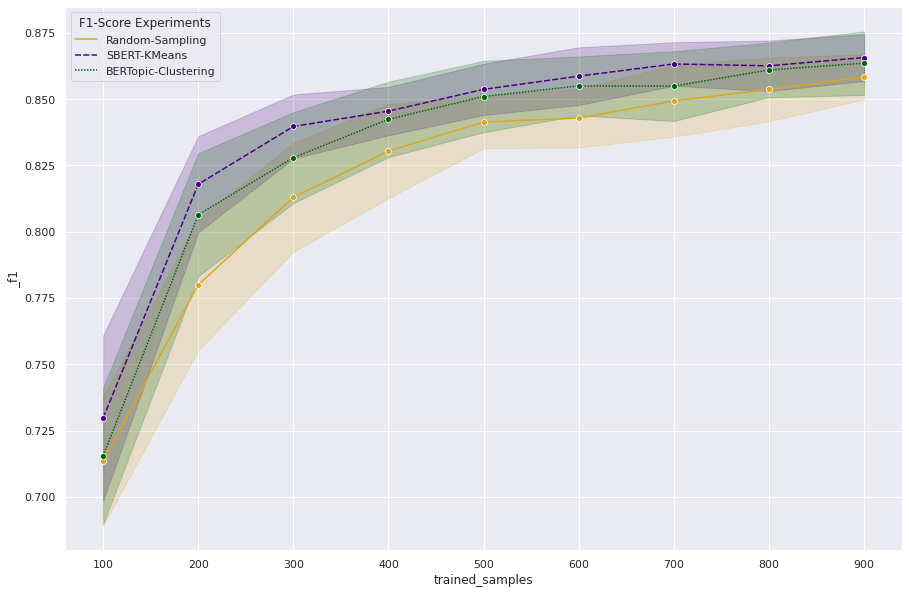

In [299]:
data = pd.DataFrame(load_result('results/full_runtimes.json'))

print_plot(data[data['trained_samples']<1000])

## Comparison Table

In [306]:
sub = data[['al_algorithm', 'random_id', 'fold_id', 'trained_samples', '_f1']]
sgrp = sub.groupby(['al_algorithm', 'trained_samples']).agg(['mean']).reset_index()
sgrp.columns = [first if second == '' else first + '_' + second for first, second in sgrp.columns.values]
sgrp = sgrp.drop(['random_id_mean', 'fold_id_mean'], axis=1)
pvt = sgrp.pivot(index='trained_samples', columns='al_algorithm')
pvt

_f1_mean                             
al_algorithm    BERTopic-Clustering Random-Sampling SBERT-KMeans
trained_samples                                                 
100                        0.715494        0.713531     0.729688
200                        0.806392        0.779985     0.817873
300                        0.827912        0.812954     0.839670
400                        0.842359        0.830404     0.845456
500                        0.850956        0.841329     0.853659
600                        0.854978        0.842863     0.858647
700                        0.854885        0.849324     0.863231
800                        0.860992        0.853632     0.862539
900                        0.863519        0.858360     0.865668
1000                       0.862672        0.862794     0.866939
1100                       0.866248        0.862383     0.871418
1200                       0.860504        0.858701     0.870491
1300                       0.867619        0.869870     0.870903
1400                       0.869729        0.865468     0.872232
1500                       0.867515        0.868997     0.874996
1600                       0.872414        0.869679     0.872426
1700                       0.872502        0.869996     0.874189
1800                       0.872324        0.869097     0.875173
1900                       0.872686        0.868329     0.878209
2000                       0.873224        0.870413     0.875788
2100                       0.876006        0.871988     0.876755
2200                       0.874412        0.874237     0.876336
2300                       0.874380        0.870066     0.877717
2400                       0.876985        0.874836     0.875649
2500                       0.878645        0.872625     0.878025
2600                       0.873169        0.876003     0.876410
2700                       0.875405        0.880766     0.877866
2800                       0.873237        0.880681     0.881495
2900                       0.870582        0.877101     0.881286
3000                       0.877485        0.882627     0.880531
3100                       0.873544        0.875877     0.883639
3200                       0.874402        0.881025     0.876923
3300                       0.877678        0.879887     0.876878
3400                       0.877459        0.884246     0.878524
3500                       0.876908        0.879845     0.874339
3600                       0.880856        0.881154     0.867514
3700                       0.878679        0.885226     0.870094
3800                       0.879143        0.883755     0.866111
3900                       0.877197        0.881968     0.872121

## Duration 

In [282]:
df = pd.DataFrame(data)
grp = df.groupby(['al_algorithm']).agg(['mean', 'std'], numeric_only=False).reset_index()
grp.columns = [first if second == '' else first + '_' + second for first, second in grp.columns.values]
grp = grp.sort_values('duration_total_seconds_mean', ascending=True).reset_index()
grp[['al_algorithm', 'duration_al_seconds_mean','duration_al_seconds_std', 'duration_ml_seconds_mean', 'duration_total_seconds_mean']]

,al_algorithm,duration_al_seconds_mean,duration_al_seconds_std,duration_ml_seconds_mean,duration_total_seconds_mean
0,Random-Sampling,0.000000,0.000000,29.501594,29.501842
1,BERTopic-Clustering,7.907694,3.641759,29.365767,37.274021
2,SBERT-KMeans,44.652347,18.385529,29.483392,74.136317
